Чтобы было больше времени на выполнение курсовой работы, задание выполнить **на наборе данных для соревнования**:

**`Тестовая выборка`** - это выборка для применения модели и загрузки на ЛБ.

In [1]:
from tqdm import tqdm
import time
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# большая чёткость графиков
#%config InlineBackend.figure_format = 'svg'
#plt.savefig("High resoltion.png",dpi=600)

import scipy.stats as st
from scipy.stats import probplot, ks_2samp, gmean, rankdata

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import Pool
from catboost.utils import get_roc_curve

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, recall_score, accuracy_score, auc, classification_report, \
                            confusion_matrix, plot_confusion_matrix, precision_recall_curve, \
                            plot_precision_recall_curve, roc_curve, plot_roc_curve)
import copy
import missingno as msno

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.processing import ColumnSelector, NumberSelector, OHEEncoder, get_num_features, get_cat_features

## Загрузка данных

In [2]:
train = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/train.csv")
test = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/test.csv")
bki = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/bki.csv")
client_profile = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/client_profile.csv")
payments = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/payments.csv")
applications_history = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/applications_history.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))
print("bki.shape = {} rows, {} cols".format(*test.shape))
print("client_profile.shape = {} rows, {} cols".format(*test.shape))
print("payments.shape = {} rows, {} cols".format(*test.shape))
print("applications_history.shape = {} rows, {} cols".format(*test.shape))

train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols
bki.shape = 165141 rows, 2 cols
client_profile.shape = 165141 rows, 2 cols
payments.shape = 165141 rows, 2 cols
applications_history.shape = 165141 rows, 2 cols


In [3]:
# 
df_list = [train, test, bki, client_profile, payments, applications_history]

## Краткий обзор признаков

### Train

In [4]:
print("train.shape = {} rows, {} cols".format(*train.shape))
train.head()

train.shape = 110093 rows, 3 cols


,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash


In [5]:
train['NAME_CONTRACT_TYPE'].unique()

array(['Cash', 'Credit Card'], dtype=object)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [7]:
train.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

False    110093
dtype: int64

**train: пропусков нет, дубликатов нет**

### Test

In [8]:
print("test.shape = {} rows, {} cols".format(*test.shape))
test.head()

test.shape = 165141 rows, 2 cols


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash


In [9]:
test['NAME_CONTRACT_TYPE'].unique()

array(['Cash', 'Credit Card'], dtype=object)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


In [11]:
test.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

False    165141
dtype: int64

**Пропусков нет, дубликатов нет**

### BKI

In [12]:
print("bki.shape = {} rows, {} cols".format(*bki.shape))
bki.head()

bki.shape = 945234 rows, 17 cols


,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,38664.00,37858.500,NaN,0.0,Consumer credit,15.0,NaN
4,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,67500.00,0.000,0.0,0.0,Credit card,116.0,NaN


In [13]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [14]:
# получим список признаков с категорией object
bki_obj_feat = list(bki.loc[:, bki.dtypes == 'object'].columns.values)
bki_obj_feat, len(bki_obj_feat)

(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], 3)

In [15]:
# список уникальных значений по категориальным фичам
for column in bki_obj_feat:
    print(f'{column}: {bki[column].unique()} \n')

CREDIT_ACTIVE: ['Active' 'Closed' 'Sold' 'Bad debt'] 

CREDIT_CURRENCY: ['currency 1' 'currency 2' 'currency 3' 'currency 4'] 

CREDIT_TYPE: ['Consumer credit' 'Credit card' 'Car loan' 'Mortgage'
 'Loan for business development' 'Microloan'
 'Loan for working capital replenishment' 'Unknown type of loan'
 'Loan for the purchase of equipment' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Real estate loan' 'Mobile operator loan'
 'Loan for purchase of shares (margin lending)'] 



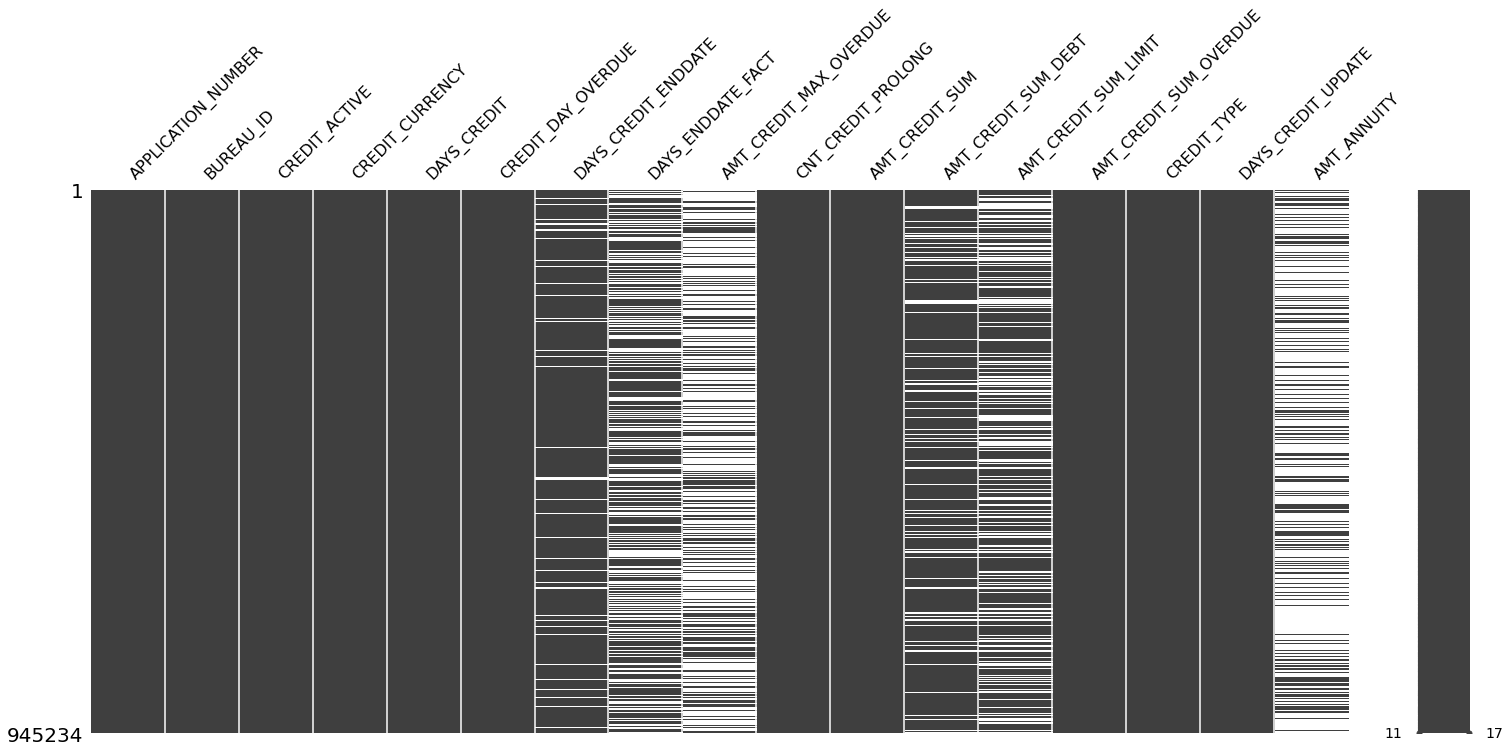

In [16]:
msno.matrix(bki);

In [17]:
bki.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

True     672103
False    273131
dtype: int64

**Есть 672103 дублирующихся записей и 273131 уникальных по 'APPLICATION_NUMBER'**

### client_profile

In [18]:
print("client_profile.shape = {} rows, {} cols".format(*client_profile.shape))
client_profile.head()

client_profile.shape = 250000 rows, 24 cols


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,...,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,...,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0


In [19]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [20]:
# получим список признаков с категорией object
client_profile_obj_feat = list(client_profile.loc[:, client_profile.dtypes == 'object'].columns.values)
client_profile_obj_feat, len(client_profile_obj_feat)

(['GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], 3)

In [21]:
# список уникальных значений по категориальным фичам
for column in client_profile_obj_feat:
    print(f'{column}: {client_profile[column].unique()} \n')

GENDER: ['F' 'M' 'XNA'] 

EDUCATION_LEVEL: ['Incomplete higher' 'Secondary / secondary special' 'Lower secondary'
 'Higher education' 'Academic degree'] 

FAMILY_STATUS: ['Civil marriage' 'Married' 'Widow' 'Single / not married' 'Separated'
 'Unknown'] 



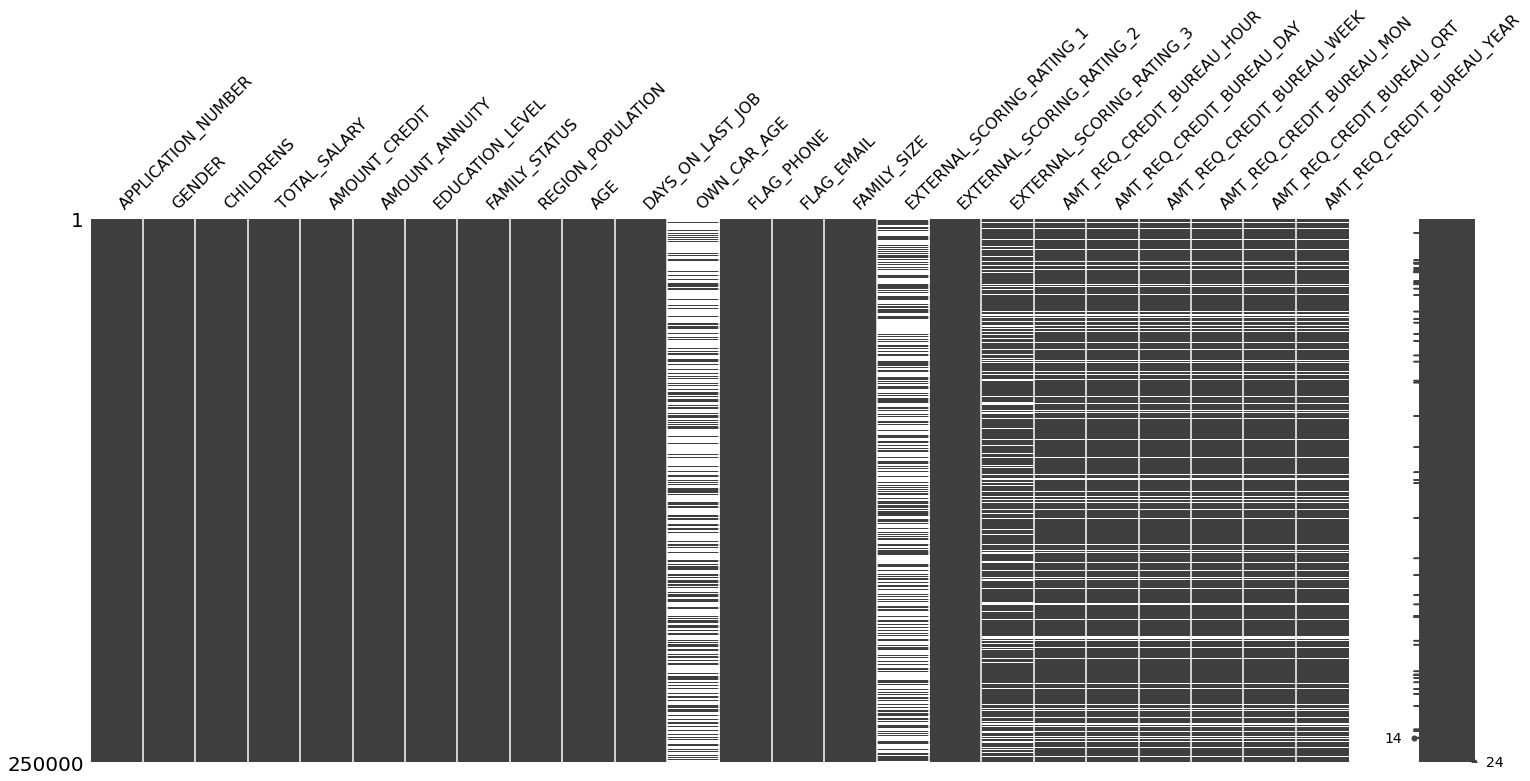

In [22]:
msno.matrix(client_profile);

In [23]:
client_profile.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

False    250000
dtype: int64

**Нет дублей**

### payments

In [24]:
print("payments.shape = {} rows, {} cols".format(*payments.shape))
payments.head()

payments.shape = 1023932 rows, 8 cols


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735,156.735


In [25]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [26]:
payments.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

True     759206
False    264726
dtype: int64

**Все признаки числовые, категориальных нет. 759206 дубликатов и 264726 уникальных**

**Только признаки `DAYS_ENTRY_PAYMENT` и `AMT_PAYMENT` имеют по 203 пропуска каждый. Остальные признаки пропусков не имеют**

### applications_history

In [27]:
print("applications_history.shape = {} rows, {} cols".format(*applications_history.shape))
applications_history.head()

applications_history.shape = 1670214 rows, 26 cols


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,...,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0
3,50087457,123499497,Cash,47041.335,450000.0,470790.0,NaN,450000.0,Approved,512,...,x-sell,-1,12.0,middle,365243.0,482.0,152.0,182.0,177.0,1.0
4,49052479,123525393,Cash,31924.395,337500.0,404055.0,NaN,337500.0,Refused,781,...,walk-in,-1,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
applications_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [29]:
# получим список признаков с категорией object
applications_history_obj_feat = list(applications_history.loc[:, applications_history.dtypes == 'object'].columns.values)
applications_history_obj_feat, len(applications_history_obj_feat)

(['NAME_CONTRACT_TYPE',
  'NAME_CONTRACT_STATUS',
  'NAME_PAYMENT_TYPE',
  'CODE_REJECT_REASON',
  'NAME_TYPE_SUITE',
  'NAME_CLIENT_TYPE',
  'NAME_GOODS_CATEGORY',
  'NAME_PORTFOLIO',
  'NAME_PRODUCT_TYPE',
  'NAME_YIELD_GROUP'],
 10)

In [30]:
# список уникальных значений по категориальным фичам
for column in applications_history_obj_feat:
    print(f'{column}: {applications_history[column].unique()} \n')

NAME_CONTRACT_TYPE: [nan 'Cash' 'Credit Card'] 

NAME_CONTRACT_STATUS: ['Approved' 'Refused' 'Canceled' 'Unused offer'] 

NAME_PAYMENT_TYPE: ['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer'] 

CODE_REJECT_REASON: ['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' 'XNA' 'VERIF' 'SYSTEM'] 

NAME_TYPE_SUITE: [nan 'Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B'
 'Other_A' 'Group of people'] 

NAME_CLIENT_TYPE: ['Repeater' 'New' 'Refreshed' 'XNA'] 

NAME_GOODS_CATEGORY: ['Mobile' 'XNA' 'Consumer Electronics' 'Construction Materials'
 'Auto Accessories' 'Photo / Cinema Equipment' 'Computers' 'Audio/Video'
 'Medicine' 'Clothing and Accessories' 'Furniture' 'Sport and Leisure'
 'Homewares' 'Gardening' 'Jewelry' 'Vehicles' 'Education'
 'Medical Supplies' 'Other' 'Direct Sales' 'Office Appliances' 'Fitness'
 'Tourism' 'Insurance' 'Additional Service' 'Weapon' 'Animals'
 'House Construction'] 

NAME_PORTFOLIO: ['POS' 'Cash' 'XNA' 'Ca

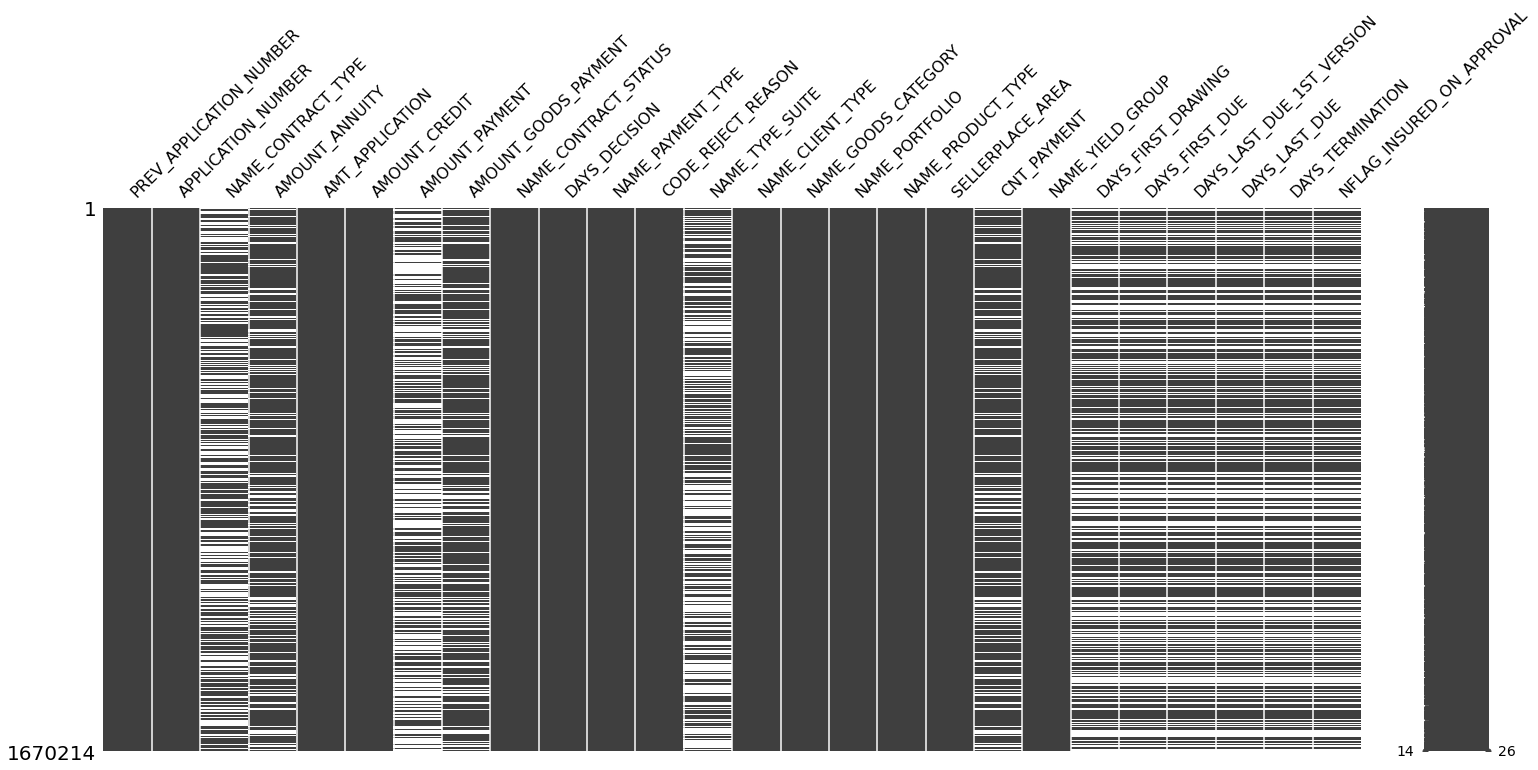

In [31]:
msno.matrix(applications_history);

In [32]:
applications_history.duplicated(subset=['APPLICATION_NUMBER']).value_counts()

True     1331357
False     338857
dtype: int64

**applications_history имеет 1331357 повторяющихся значений и 338857 уникальных по 'APPLICATION_NUMBER'. Надо подумать как сконкатенировать**

### Целевая переменная

In [33]:
train['TARGET'].unique()

array([0, 1], dtype=int64)

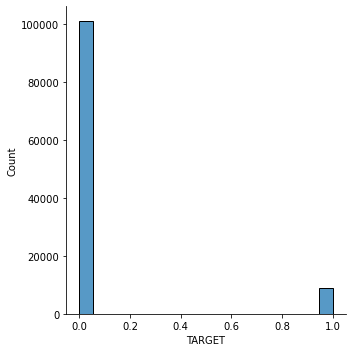

In [34]:
sns.displot(train, x='TARGET');

In [35]:
train['TARGET'].value_counts()[0] / train['TARGET'].value_counts()[1]

11.37417106889963

Дисбаланс классов 11.4 к 1-му.

**Объеденим client_profile с трейном и тестом**

In [36]:
# конкатенируем client_profile. Он единственный не содержит дубликатов
train = pd.merge(train, client_profile, on='APPLICATION_NUMBER', how='left')
X_test = pd.merge(test, client_profile, on='APPLICATION_NUMBER', how='left')

# не конкатенируем из-да дублей
#df = pd.merge(df, bki, on='APPLICATION_NUMBER', how='left')
#df = pd.merge(df, payments, on='APPLICATION_NUMBER', how='left')
#df = pd.merge(df, applications_history, on='APPLICATION_NUMBER', how='left')
train.head(5)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
3,123710391,1,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
**Функции кросс-валидации**

In [37]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели LightGBM.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=0, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        # print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели XGBoost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores, encoders = [], [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=0,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        # print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, encoders, oof_preds

In [38]:
def get_cat_features(df):
    """
    функция возвращает список признаков
    :param df:
    :return: list
    """
    categorical_features = df.select_dtypes(include=[np.object])
    return categorical_features.columns.to_list()

In [39]:
cat_features = get_cat_features(train)
cat_features

['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS']

# Задание 1

**Обучить алгоритмы `LightGBM` и `XGBoost`, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.**

In [40]:
target, data = train['TARGET'], train.drop(['TARGET'], axis=1)

In [41]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 8,
    "seed": 42
}

xgb_cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [42]:
xgb_estimators, _, xgb_oof_preds = xgboost_cross_validation(
    xgb_params, data, target, xgb_cv, cat_features
)

Thu Apr 22 20:17:56 2021, Cross-Validation, 110093 rows, 25 cols
Score by each fold: [0.73901, 0.73029, 0.71994, 0.70268, 0.73241, 0.71845, 0.72533, 0.71446, 0.70497, 0.70755]


Score by each fold: [0.73901, 0.73029, 0.71994, 0.70268, 0.73241, 0.71845, 0.72533, 0.71446, 0.70497, 0.70755]

In [43]:
score = roc_auc_score(target, xgb_oof_preds)
print(f"Score = {round(score, 4)}")

Score = 0.7025


In [44]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': True,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

lgbm_cv = KFold(n_splits=7, random_state=1, shuffle=True)

In [45]:
lgbm_estimators, lgbm_oof_preds = lightgbm_cross_validation(
    lgbm_params, data, target, lgbm_cv
)

Thu Apr 22 20:19:44 2021, Cross-Validation, 110093 rows, 25 cols
Score by each fold: [0.71242, 0.72574, 0.72173, 0.71592, 0.7348, 0.71319, 0.70672]


Score by each fold: [0.7124, 0.7241, 0.72279, 0.71697, 0.73438, 0.71215, 0.70829]

In [46]:
score = roc_auc_score(target, lgbm_oof_preds)
print(f"Score = {round(score, 4)}")

Score = 0.7185


Чтобы понять можно ли смешивать модели, посчитаем корреляцию между прогнозами трейна. Составим матрицу с out-of-fold прогнозами моделей и посчитаем корреляцию между ними.

**Prediction Correlation**

In [47]:
lgbm_oof_preds

array([0.14025125, 0.49431974, 0.37914719, ..., 0.50569478, 0.28593276,
       0.48474344])

In [48]:
scores_train = pd.DataFrame({
    "lgbm": lgbm_oof_preds,
    "xgb": xgb_oof_preds,
})

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

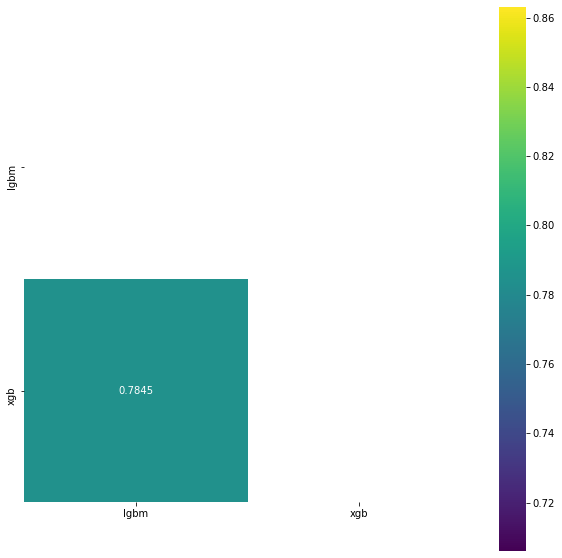

In [49]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes);

 **Применим модели на тестовую выборку**

In [50]:
def xgboost_cross_validation_predict(models, X, cv, categorical = None):
    """
    Предсказания для модели XGBoost.

    Parameters
    ----------
    models: list
        Список моделей

    X: pandas.core.frame.DataFrame
        Матрица признаков для прогнозов модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    encoders = {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    
    i = 0
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        dtrain = xgb.DMatrix(x_train)
        dvalid = xgb.DMatrix(x_valid)
        oof_preds[valid_idx] = models[i].predict(dvalid)
        i += 1


    #print(f"Score by each fold: {folds_preds}")
    #print("="*65)
    return oof_preds

In [51]:
# предсказания XGB
xgb_oof_test_preds = xgboost_cross_validation_predict(xgb_estimators, X_test, xgb_cv, cat_features)

Thu Apr 22 20:20:31 2021, Cross-Validation, 165141 rows, 25 cols


In [52]:
xgb_oof_test_preds

array([0.07611421, 0.24183679, 0.16415544, ..., 0.16096108, 0.13539006,
       0.13260722])

In [53]:
def lightgbm_cross_validation_predict(models, X, cv, categorical = None):
    """
    Предсказания для модели LightGBM.

    Parameters
    ----------
    models: list
        Список обученных моделей.

    X: pandas.core.frame.DataFrame
        Матрица признаков для прогноза.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    i = 0
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        oof_preds[valid_idx] = models[i].predict_proba(x_valid)[:, 1]
        i += 1

    print("="*65)
    return oof_preds

In [54]:
lgbm_oof_test_preds = lightgbm_cross_validation_predict(lgbm_estimators, X_test, lgbm_cv, cat_features)

Thu Apr 22 20:20:32 2021, Cross-Validation, 165141 rows, 25 cols


**Построим корреляции предсказаний теста**

In [55]:
scores_test = pd.DataFrame({
    "lgbm test": lgbm_oof_test_preds,
    "xgb test": xgb_oof_test_preds,
})

corr = scores_test.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

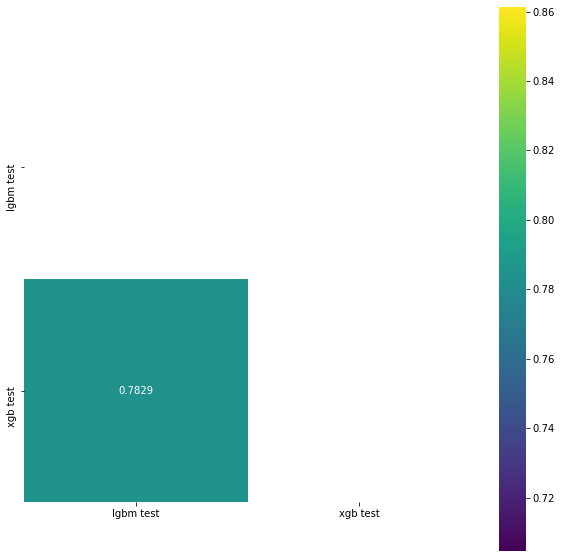

In [56]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes);

**Корреляция предсказаний на трейне была 0.7845. На тесте = 0.7829**

---

# Задание 2

**Усреднить прогнозы с помощью арифметического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.**

In [57]:
# Arithmetic mean
scores_mean = scores_train.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.719


Арифметическое среднее даёт 0.719 - лучше, чем было в lgbm = 0.7185.

In [58]:
# Geometric Mean
scores_mean = gmean(scores_train, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7154


Геометрическое среднее даёт 0.7154 - хуже.

In [59]:
# Rankdata
# ROC-AUC / GINI
scores_mean = scores_train.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.716


In [60]:
scores_mean = gmean(scores_train.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.718


**Наилучший скор получается у среднего арифметического**.

---

# Задание 3

**Обучить `CatBoost`, получить OOF прогнозы и выполнить задание 1 для трех моделей**.

Обучаем алгоритм CatBoost, получаем OOF прогнозы

In [61]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели XGBoost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores, encoders = [], [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        #train_pool = cb.Pool(x_train, y_train, cat_features=categorical)
        #valid_pool = cb.Pool(x_valid, y_valid, cat_features=categorical)

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train,
            y_train,
            categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            verbose_eval=0,
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        # print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, encoders, oof_preds

In [62]:
cb_params = {
    #"n_estimators": 750,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    #"max_bin": 20,
    "verbose": 0,
    "max_depth": 6,
    #"l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": -1,
    "random_seed": 42
}

cb_cv = KFold(n_splits=10, random_state=42, shuffle=True)

cb_estimators, cb_encoders, cb_oof_preds = catboost_cross_validation(
    cb_params, data, target, cb_cv, cat_features
)

Thu Apr 22 20:20:37 2021, Cross-Validation, 110093 rows, 25 cols
Score by each fold: [0.73674, 0.73179, 0.72195, 0.71695, 0.72922, 0.72058, 0.72701, 0.71815, 0.71625, 0.71166]


In [63]:
lgbm_oof_preds, xgb_oof_preds, cb_oof_preds,

(array([0.14025125, 0.49431974, 0.37914719, ..., 0.50569478, 0.28593276,
        0.48474344]),
 array([0.02460046, 0.16096108, 0.06466153, ..., 0.08562571, 0.03146516,
        0.08508746]),
 array([0.02424596, 0.08535358, 0.04240942, ..., 0.08094838, 0.03117069,
        0.08706344]))

In [64]:
score = roc_auc_score(target, cb_oof_preds)
print(f"Score = {round(score, 4)}")

Score = 0.7223


**оценим корреляцию прогнозов на обучающей выборке**

In [65]:
scores_train = pd.DataFrame({
    "lgbm train": lgbm_oof_preds,
    "xgb train": xgb_oof_preds,
    "cat boost train": cb_oof_preds,
})

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

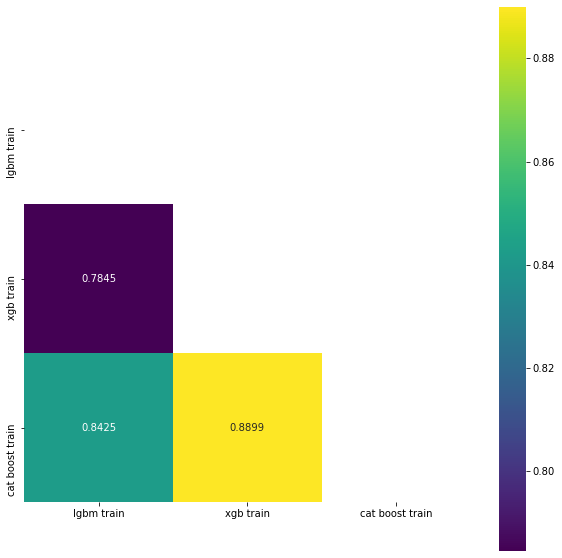

In [66]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes);

**Самая низкая корреляция на трейне между XGBoost и lightgbm**.

**Применим модели на тестовую выборку**

In [67]:
def catboost_cross_validation_predict(models, X, cv, categorical = None):
    """
    Предсказания для модели LightGBM.

    Parameters
    ----------
    models: list
        Список обученных моделей.

    X: pandas.core.frame.DataFrame
        Матрица признаков для прогноза.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    i = 0
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        oof_preds[valid_idx] = models[i].predict_proba(x_valid)[:, 1]
        i += 1

    print("="*65)
    return oof_preds

In [68]:
catboost_oof_test_preds = catboost_cross_validation_predict(cb_estimators, X_test, cb_cv, cat_features)

Thu Apr 22 20:25:15 2021, Cross-Validation, 165141 rows, 25 cols


In [69]:
catboost_oof_test_preds

array([0.06522411, 0.25766805, 0.16121411, ..., 0.0827012 , 0.02391673,
       0.05603946])

**Построим корреляции предсказаний теста трёх моделей**

In [70]:
scores_test = pd.DataFrame({
    "lgbm test": lgbm_oof_test_preds,
    "xgb test": xgb_oof_test_preds,
    "cb test": catboost_oof_test_preds,
    
})

corr = scores_test.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

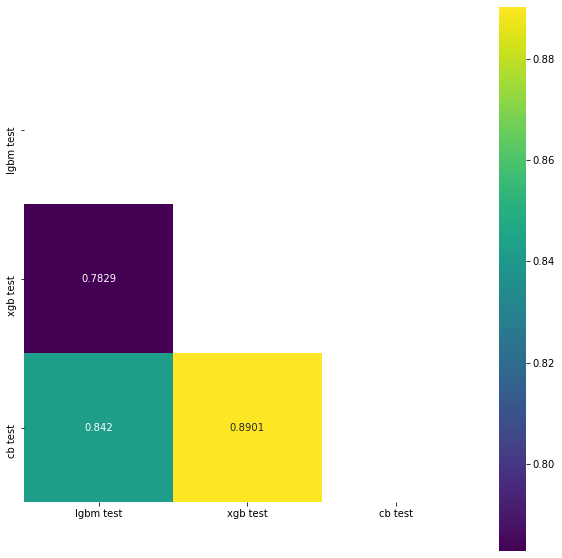

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes);

**Самая низкая корреляция на тесте там же где и на трейне: между XGBoost и lightgbm**.

# Задание 4

**Выполнить задание 2 для трех моделей**.

Усреднить прогнозы с помощью арифметического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [72]:
# Arithmetic mean
scores_mean = scores_train.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7209


In [73]:
# Geometric Mean
scores_mean = gmean(scores_train, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7213


In [74]:
# Rankdata
# ROC-AUC / GINI
scores_mean = scores_train.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7206


In [75]:
scores_mean = gmean(scores_train.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7215


**Самый высокий скор 0.7212 даёт геометрическое среднее рангов**

**Лучшая модель: CatBoost со скором 0.7222**

5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

6. (опция) Обучить алгоритм `RandomForest` (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.